# <center>Построение простейших моделей прогнозирования</center>

In [1]:
import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.seasonal as sm

import matplotlib.pyplot as plt
%matplotlib inline

## Исходные данные (объемы пассажирских авиаперевозок)

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [3]:
passengers.head()

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


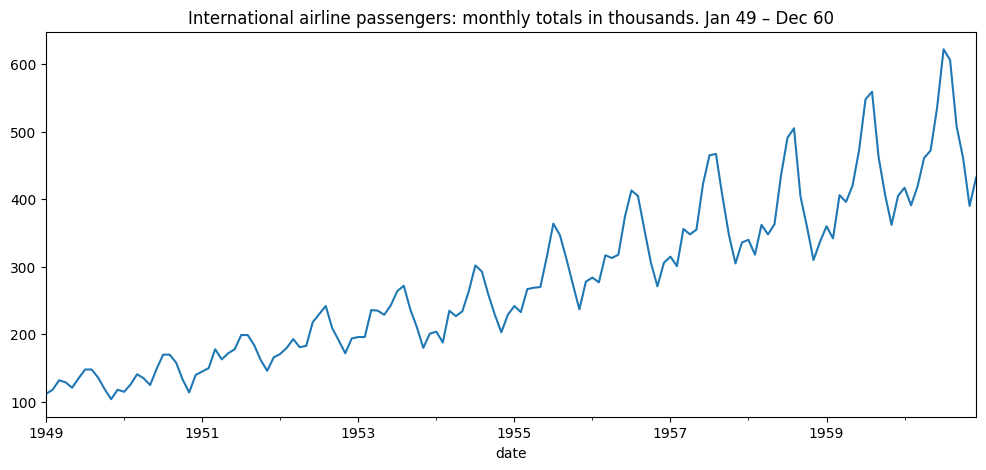

In [4]:
passengers['num_passengers'].plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 60')
plt.show()

Временной ряд обладает трендом и годовой сезонностью, которые должны быть учтены при построении моделей прогнозирования. Наличие тренда и сезонности проявляется на коррелограмме. Для построения коррелограммы воспользуемся функцией `plot_acf` из библиотеки `statsmodels`.

Опция `lags` позволяет задавать количество лагов для вычисления значений автокорреляции.

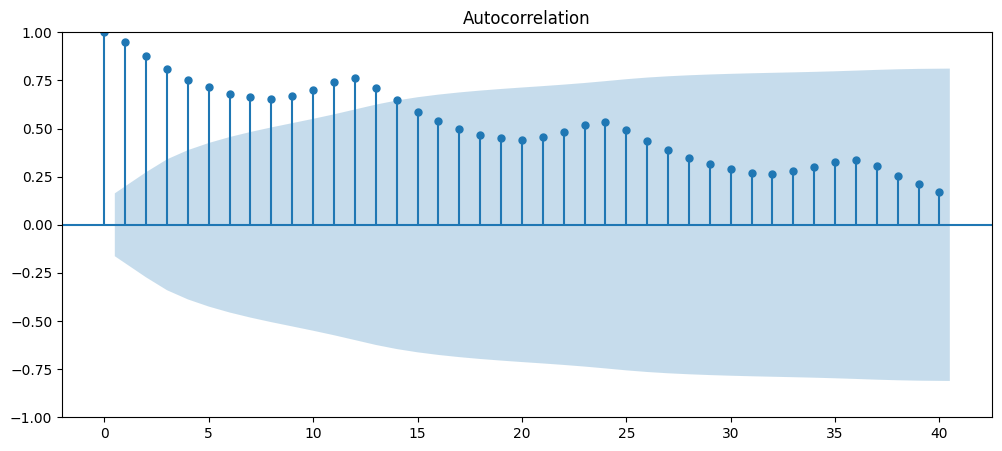

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(passengers['num_passengers'], lags=40, ax=ax)
plt.show()

<div class="alert alert-info">

<h3> Задание 1</h3>
<p></p>
Постройте наивную сезонную модель прогнозирования. Данная модель предполагает, что количество пассажиров в январе 1961 г. будет таким же, как и в январе 1960 г. С помощью полученной модели получите прогноз на 3 года вперед и отобразите результат на графике.
<p></p>
  
</div>

### Наивная сезонная модель прогнозирования

In [6]:
naive_forecast = pd.concat([passengers.tail(12)] * 3)
naive_forecast.index = pd.date_range('1961-01-01','1963-12-01',freq='MS')

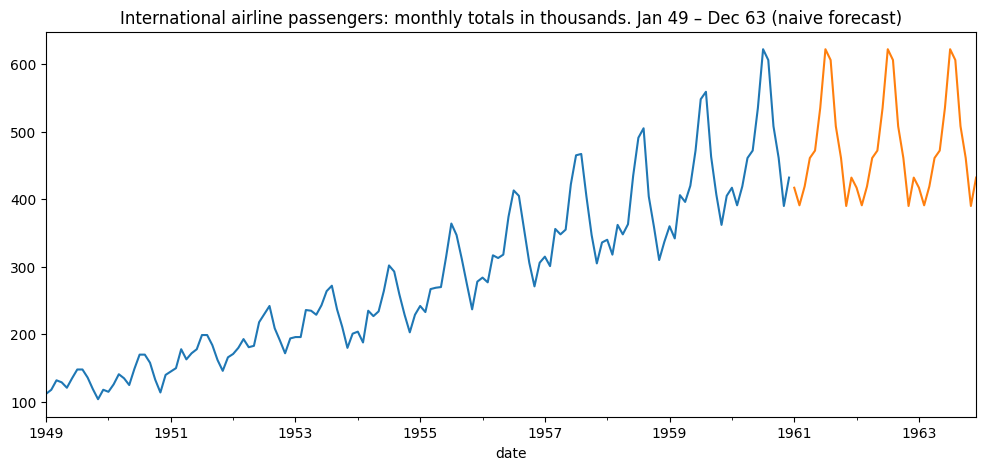

In [7]:
passengers['num_passengers'].plot(figsize=(12,5))
naive_forecast['num_passengers'].plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63 (naive forecast)')
plt.show()

<div class="alert alert-info">

<h3> Задание 2</h3>
<p></p>
Наивная сезонная модель прогнозирования не учитывает тренд временного ряда. Воспользуйтесь методом экстраполяции тренда, постройте прогноз также на 3 года и отобразите результат на графике.
    
<em>Комментарий: пока реализуйте только метод экстраполяции тренда! Не спешите объединять модели.</em>
<p></p>
  
</div>

### Метод экстраполяции тренда

In [8]:
coef = np.array([h * (passengers['num_passengers'].iloc[-1] - passengers['num_passengers'].iloc[0]) / (passengers.shape[0] - 1) for h in range(1, 38)])
trend_forecast_data = passengers['num_passengers'].iloc[-1] + coef

In [9]:
trend_forecast = pd.DataFrame({'date': pd.date_range('1960-12-01','1963-12-01',freq='MS'), 'num_passengers': trend_forecast_data}).set_index('date')

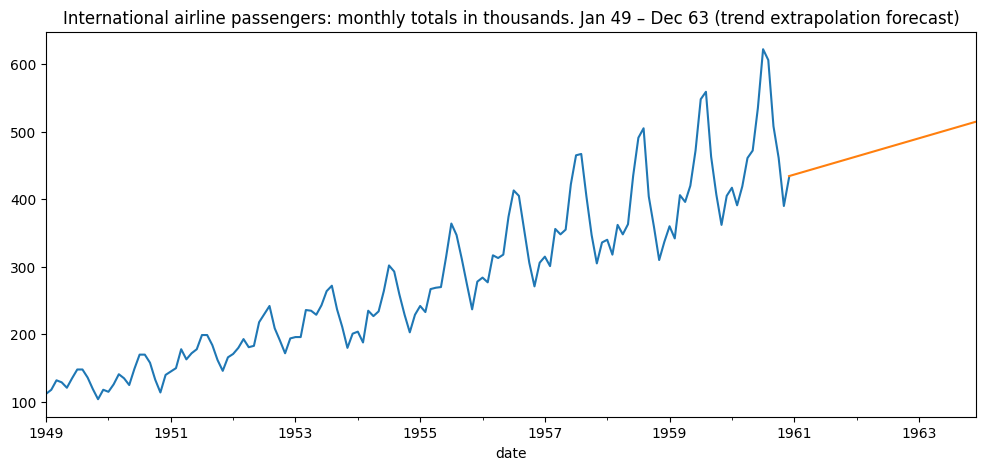

In [10]:
passengers['num_passengers'].plot(figsize=(12,5))
trend_forecast['num_passengers'].plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63 (trend extrapolation forecast)')
plt.show()

<div class="alert alert-info">

<h3> Задание 3</h3>
<p></p>
В результате выполнения предыдущих заданий вы получили две модели, каждая из которых описывает только одну из компонент ряда: либо тренд, либо сезонность. Попробуем их объединить. Для этого:
    <p></p>
    <li>вычтите из исходного ряда трендовую составляющую, постройте коррелограмму полученного ряда остатков;</li>
    <li>для ряда остатков постройте наивную сезонную модель.</li>
    
 Получите прогноз на 3 года вперед с помощью комбинации моделей. Результат отобразите на графике.
<p></p>
  
</div>

### Вычитание из исходного ряда трендовой составляющей

In [11]:
coef = ([h * (passengers['num_passengers'].iloc[-1] - passengers['num_passengers'].iloc[0]) / (passengers.shape[0] - 1) for h in range(1, passengers.shape[0] + 1)])
trend_data = passengers['num_passengers'].iloc[0] + coef

In [12]:
trend_df = pd.DataFrame({'date': pd.date_range('1949-01-01','1960-12-01',freq='MS'), 'num_passengers': trend_data}).set_index('date')

In [13]:
residuals = passengers - trend_df

### Коррелограмма полученного ряда остатков

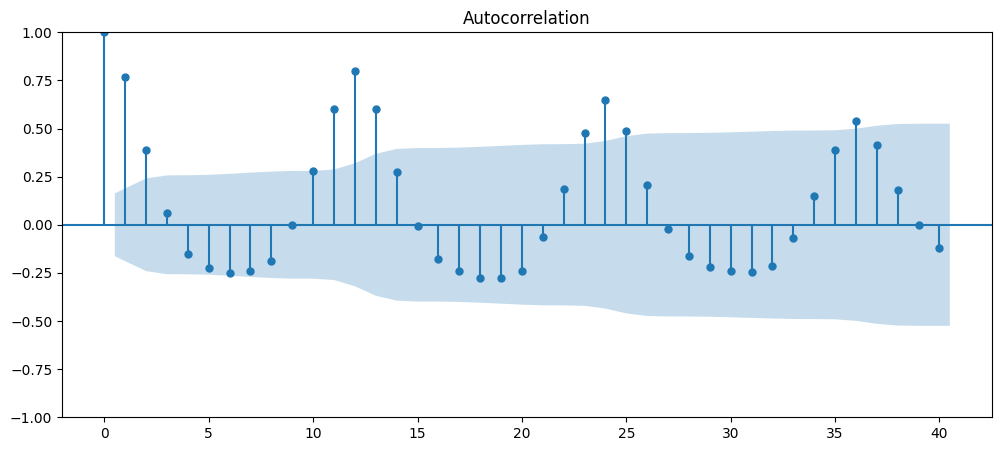

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(residuals, lags=40, ax=ax)
plt.show()

### Наивная сезонная модель для остатков

In [15]:
naive_forecast_for_residuals = pd.concat([residuals.tail(12)] * 3)
naive_forecast_for_residuals.index = pd.date_range('1961-01-01', '1963-12-01', freq='MS')

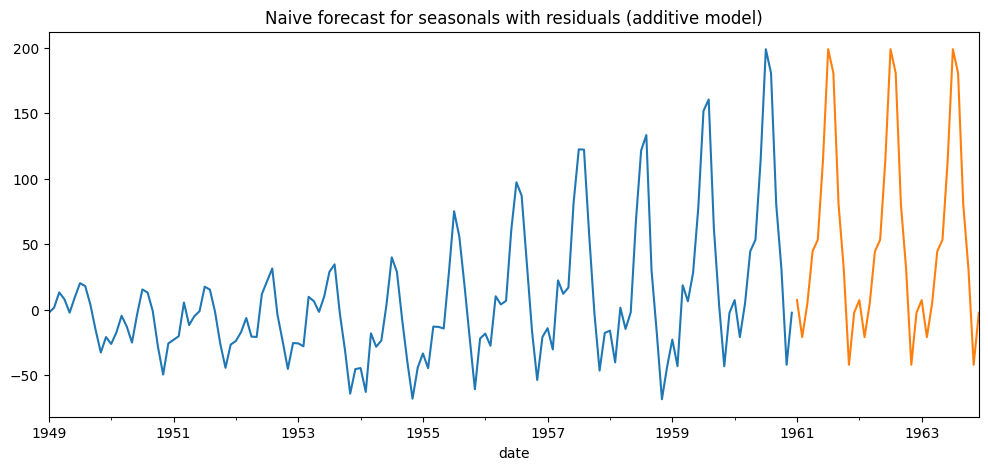

In [16]:
residuals['num_passengers'].plot(figsize=(12,5))
naive_forecast_for_residuals['num_passengers'].plot()
plt.title('Naive forecast for seasonals with residuals (additive model)')
plt.show()

### Прогноз на 3 года вперед с помощью комбинации моделей

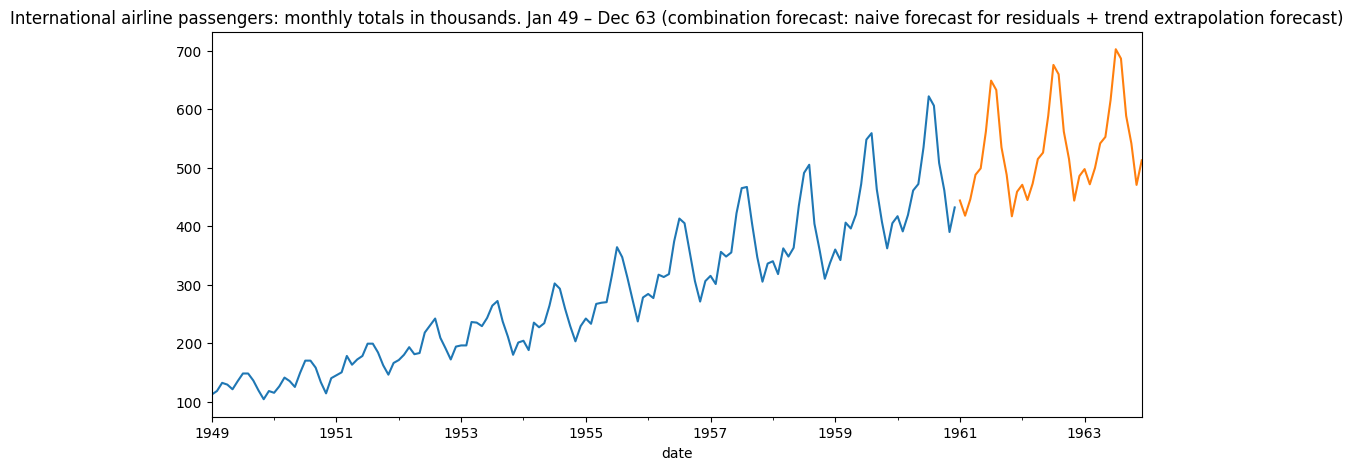

In [17]:
passengers['num_passengers'].plot(figsize=(12,5))
(naive_forecast_for_residuals['num_passengers'] + trend_forecast['num_passengers']).plot()
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63 (combination forecast: naive forecast for residuals + trend extrapolation forecast)')
plt.show()

### Мультипликативная сезонность

Во временном ряду пассажирских авиаперевозок наблюдается **мультипликативная сезонность**, которая характеризуется увеличением амплитуды сезонных колебаний. В случае когда амплитуда сезонных колебаний не меняется, говорят об **аддитивной сезонности**.

Ряд с трендом и аддитивной сезонностью может быть представлен в виде суммы его компонент:

$$y(t)=b(t)+s(t)+\epsilon(t),$$

где $b(t)$ &ndash; трендовая, $s(t)$ &ndash; сезонная, а $\epsilon(t)$ &ndash; случайная компоненты ряда.

Ряд с мультипликативной сезонностью представляет собой произведение данных компонент:

$$y(t)=b(t)\times s(t)\times \epsilon(t).$$

<div class="alert alert-info">

<h3> Задание 4</h3>
<p></p>
Постройте мультипликативную модель прогнозирования, получите прогноз на 3 года вперед и отобразите результат на графике. Также, для сравнения, отобразите на графике прогноз модели из предыдущего задания.
<p></p>
  
</div>

In [18]:
passengers.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='date', length=144, freq=None)

Извлечение компонент тренда, сезонности и остатков (для демонстрации)

In [24]:
decomposition = sm.seasonal_decompose(passengers, model='add', extrapolate_trend='freq')

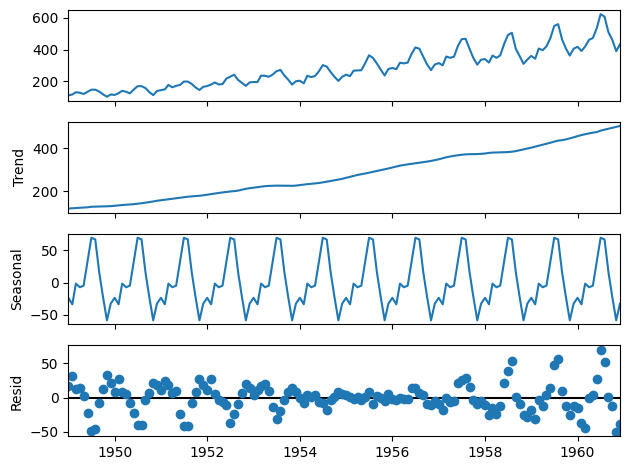

In [25]:
decomposition.plot()
plt.show()

### Мультипликативная модель прогнозирования

In [24]:
resid = passengers / trend_df

In [25]:
naive_forecast_for_resid = pd.concat([resid.tail(12)] * 3)
naive_forecast_for_resid.index = pd.date_range('1961-01-01','1963-12-01',freq='MS')

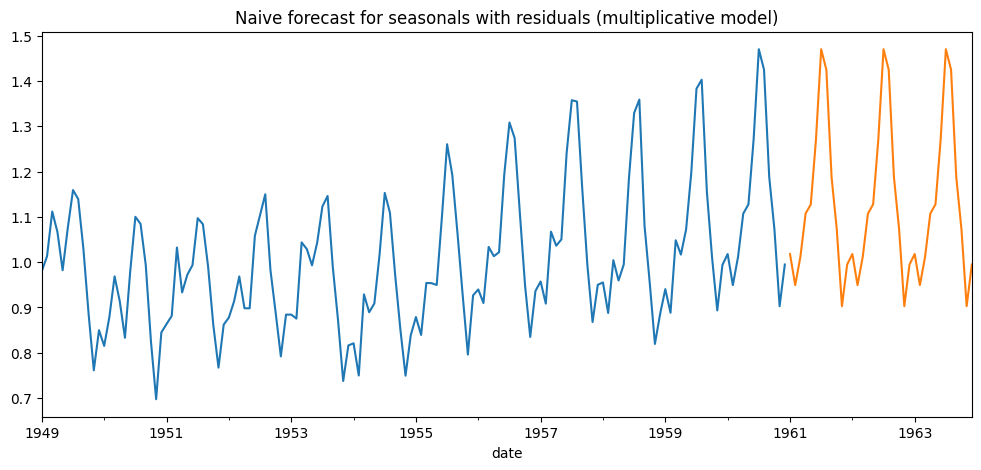

In [26]:
resid['num_passengers'].plot(figsize=(12,5))
naive_forecast_for_resid['num_passengers'].plot(figsize=(12,5))
plt.title('Naive forecast for seasonals with residuals (multiplicative model)')
plt.show()

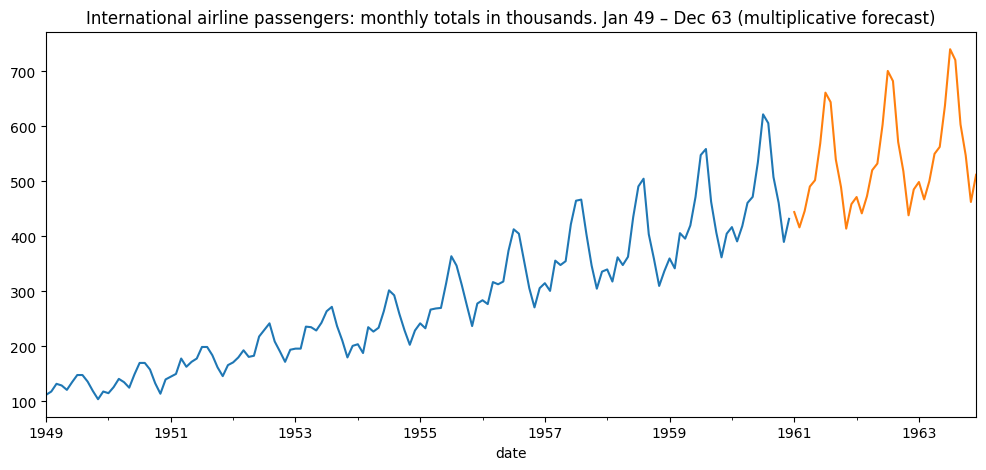

In [27]:
passengers['num_passengers'].plot(figsize=(12,5))
(naive_forecast_for_resid['num_passengers'] * trend_forecast['num_passengers']).plot(figsize=(12,5))
plt.title('International airline passengers: monthly totals in thousands. Jan 49 – Dec 63 (multiplicative forecast)')
plt.show()